In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import DarkNews as dn

from DarkNews import const

from DarkNews.GenLauncher import GenLauncher

from DarkNews import Cfourvec as Cfv

from particle import literals as lp
from pathlib import Path

In [3]:
from ToyAnalysis import analysis_decay as ad
from ToyAnalysis import analysis as an
from ToyAnalysis import fit_functions as fit
from ToyAnalysis.plot_tools import plot_all_rates as MBplotter
from pathlib import Path

0.5101933149851114

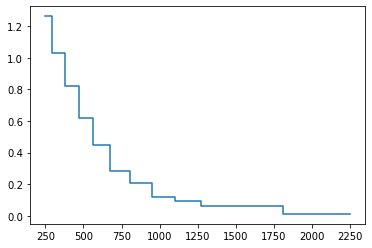

In [139]:
import scipy

def get_pval(df_prob, ndof=6.7):
    bin_e = np.genfromtxt(f'ToyAnalysis/data/MB_data_release/nue2020/numode/miniboone_binboundaries_nue_lowe.txt')
    NP_MC, _ = np.histogram(df_prob['reco_Enu']*1e3, weights=df_prob['reco_w'], bins=bin_e)
    bw = bin_e[1:]-bin_e[:-1]
    plt.step((bin_e[1:]+bin_e[:-1])/2,NP_MC/bw, where ='mid')
    chi2=fit.chi2_MiniBooNE_2020(NP_MC, NP_MC.sum())
    return scipy.stats.chi2.sf(chi2, 8.7)
get_pval(my_dfs_prob[1])

# Generation of the BPs

In [532]:
common_kwargs = {'loglevel': 'ERROR', 'HNLtype': 'dirac', 'neval': 1e4}

# TMM
kwargs = {'mu_tr_mu4': 1.4e-6, 'm4': 0.470, 'decay_product': 'photon'}
gen_1 = dn.GenLauncher(experiment='miniboone_fhc', **kwargs, **common_kwargs)
gen_1_dirt = dn.GenLauncher(experiment='miniboone_fhc_dirt', **kwargs, **common_kwargs)
genmuB_1 = dn.GenLauncher(experiment='microboone', **kwargs, **common_kwargs)
genmuB_1_dirt = dn.GenLauncher(experiment='microboone_dirt', **kwargs, **common_kwargs)
df_1 = gen_1.run()
df_1_dirt = gen_1_dirt.run()
df_1_muB = genmuB_1.run()
df_1_muB_dirt = genmuB_1_dirt.run()

# Vectors
M4 = 0.107
M5 = 0.150
kwargs = {'UD4': 1/np.sqrt(2), 'UD5': 1/np.sqrt(2), 'Umu5': 1e-4, 'Umu4': 1e-4, 'gD': 2, 'epsilon': 3.4e-4, 'mzprime': 0.03, 'm4': M4, 'm5': M5}
gen_2 = dn.GenLauncher(experiment='miniboone_fhc', **kwargs, **common_kwargs)
gen_2_dirt = dn.GenLauncher(experiment='miniboone_fhc_dirt', **kwargs, **common_kwargs)
gen_2_muB = dn.GenLauncher(experiment='microboone', **kwargs, **common_kwargs)
gen_2_muB_dirt = dn.GenLauncher(experiment='microboone_dirt', **kwargs, **common_kwargs)
df_2 = gen_2.run()
df_2_dirt = gen_2_dirt.run()
df_2_muB = gen_2_muB.run()
df_2_muB_dirt = gen_2_muB_dirt.run()

kwargs = {'UD4': 1/np.sqrt(2), 'UD5': 1/np.sqrt(2), 'Umu5': 1e-3, 'Umu4': 1e-3, 'gD': 2, 'epsilon': 0.75e-2, 'mzprime': 1.25, 'm4': M4, 'm5': M5}
gen_3 = dn.GenLauncher(experiment='miniboone_fhc',  **kwargs, **common_kwargs)
gen_3_dirt = dn.GenLauncher(experiment='miniboone_fhc_dirt',  **kwargs, **common_kwargs)
gen_3_muB = dn.GenLauncher(experiment='microboone', **kwargs, **common_kwargs)
gen_3_muB_dirt = dn.GenLauncher(experiment='microboone_dirt', **kwargs, **common_kwargs)
df_3 = gen_3.run()
df_3_dirt = gen_3_dirt.run()
df_3_muB = gen_3_muB.run()
df_3_muB_dirt = gen_3_muB_dirt.run()

# Scalars
M4 = 0.140
M5 = 0.2
theta_e = 2.5e-3
theta_numu = 4e-3
theta_nucleon = 4e-3
kwargs = {'mzprime': None, 'mhprime': 1.0, 'm4': M4, 'm5': M5, 's_mu5': theta_numu, 's_45': 1.0,  'deS': theta_e, 'dprotonS': theta_nucleon, 'dneutronS': theta_nucleon}
gen_4 = dn.GenLauncher(experiment='miniboone_fhc', **kwargs, **common_kwargs)
gen_4_dirt = dn.GenLauncher(experiment='miniboone_fhc_dirt', **kwargs, **common_kwargs)
gen_4_muB = dn.GenLauncher(experiment='microboone', **kwargs, **common_kwargs)
gen_4_muB_dirt = dn.GenLauncher(experiment='microboone_dirt', **kwargs, **common_kwargs)
df_4 = gen_4.run()
df_4_dirt = gen_4_dirt.run()
df_4_muB = gen_4_muB.run()
df_4_muB_dirt = gen_4_muB_dirt.run()


theta_e = 0.8e-3
theta_numu = 1e-3
theta_nucleon = 1.4e-4
kwargs = {'mzprime': None, 'mhprime': 0.03, 'm4': M4, 'm5': M5, 's_mu5': theta_numu, 's_45': 1.0,  'deS': theta_e, 'dprotonS': theta_nucleon, 'dneutronS': theta_nucleon}
gen_5 = dn.GenLauncher(experiment='miniboone_fhc', **kwargs, **common_kwargs)
gen_5_dirt = dn.GenLauncher(experiment='miniboone_fhc_dirt', **kwargs, **common_kwargs)
gen_5_muB = dn.GenLauncher(experiment='microboone',**kwargs, **common_kwargs)
gen_5_muB_dirt = dn.GenLauncher(experiment='microboone_dirt',**kwargs, **common_kwargs)
df_5 = gen_5.run()
df_5_dirt = gen_5_dirt.run()
df_5_muB = gen_5_muB.run()
df_5_muB_dirt = gen_5_muB_dirt.run()


/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/model.py:587: RuntimeWarning: invalid value encountered in sqrt
  + self._gschi * ( Ulep_dark_only - np.dot( self.Ulep[:,3:], self.D_dark[3:]))
/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/model.py:587: RuntimeWarning: invalid value encountered in sqrt
  + self._gschi * ( Ulep_dark_only - np.dot( self.Ulep[:,3:], self.D_dark[3:]))


In [533]:
from DarkNews.MC import get_merged_MC_output

In [534]:
my_dfs = [df_1, df_2, df_3, df_4, df_5]
my_dfs_dirt = [df_1_dirt, df_2_dirt, df_3_dirt, df_4_dirt, df_5_dirt]
my_dfs_muB = [df_1_muB, df_2_muB, df_3_muB, df_4_muB, df_5_muB]
my_dfs_muB_dirt = [df_1_muB_dirt, df_2_muB_dirt, df_3_muB_dirt, df_4_muB_dirt, df_5_muB_dirt]

##########    
# MiniBooNE -- smear, signal selection and filter decays
my_dfs_prob = []
my_dfs_dirt_prob = []
final_dfs = []
for df, dfd in zip(my_dfs, my_dfs_dirt):
    if df.attrs['model'].mu_tr_mu4 > 0:
        dfp   = an.compute_spectrum(ad.select_MB_decay_expo_prob(df, l_decay_proper_cm=df.attrs['N4_ctau0']), EVENT_TYPE='photon')
        dfp_d = an.compute_spectrum(ad.select_MB_decay_dirt_no_filt(dfd, l_decay_proper_cm=dfd.attrs['N4_ctau0']), EVENT_TYPE='photon')
    else:
        dfp   = an.compute_spectrum(ad.select_MB_decay_expo_prob(df, l_decay_proper_cm = df.attrs['N5_ctau0']), EVENT_TYPE='both')
        dfp_d = an.compute_spectrum(ad.select_MB_decay_dirt_no_filt(dfd, l_decay_proper_cm = dfd.attrs['N5_ctau0']), EVENT_TYPE='both')
    my_dfs_prob.append(dfp)
    my_dfs_dirt_prob.append(dfp_d)
    final_dfs.append(get_merged_MC_output(dfp,dfp_d))

##########    
# MicroBooNE -- smear, signal selection and filter decays
my_dfs_muB_prob = []
my_dfs_muB_dirt_prob = []
final_dfs_muB = []
for df, dfd in zip(my_dfs_muB, my_dfs_muB_dirt):
    if df.attrs['model'].mu_tr_mu4 > 0:
        dfp   = an.compute_spectrum(ad.select_muB_decay_prob(df, l_decay_proper_cm=df.attrs['N4_ctau0']), EVENT_TYPE='photon', EXP='microboone')
        dfp_d = an.compute_spectrum(ad.select_muB_decay_dirt(dfd, l_decay_proper_cm=dfd.attrs['N4_ctau0']), EVENT_TYPE='photon', EXP='microboone')
    else:
        dfp   = an.compute_spectrum(ad.select_muB_decay_prob(df, l_decay_proper_cm = df.attrs['N5_ctau0']), EVENT_TYPE='both', EXP='microboone')
        dfp_d = an.compute_spectrum(ad.select_muB_decay_dirt(dfd, l_decay_proper_cm = dfd.attrs['N5_ctau0']), EVENT_TYPE='both', EXP='microboone')
    my_dfs_muB_prob.append(dfp)
    my_dfs_muB_dirt_prob.append(dfp_d)
    final_dfs_muB.append(get_merged_MC_output(dfp,dfp_d))

/Users/matheushostert/Repos/DarkNews-generator/examples/ToyAnalysis/analysis.py:425: RuntimeWarning: invalid value encountered in sqrt
  Pe  = np.sqrt(Evis**2 - const.m_e**2)
/Users/matheushostert/Repos/DarkNews-generator/examples/ToyAnalysis/analysis.py:425: RuntimeWarning: invalid value encountered in sqrt
  Pe  = np.sqrt(Evis**2 - const.m_e**2)
/Users/matheushostert/Repos/DarkNews-generator/examples/ToyAnalysis/analysis.py:324: RuntimeWarning: invalid value encountered in double_scalars
  eff_asym	= w_asym.sum()/w_tot
/Users/matheushostert/Repos/DarkNews-generator/examples/ToyAnalysis/analysis.py:325: RuntimeWarning: invalid value encountered in double_scalars
  eff_ovl		= w_ovl.sum()/w_tot
/Users/matheushostert/Repos/DarkNews-generator/examples/ToyAnalysis/analysis.py:326: RuntimeWarning: invalid value encountered in double_scalars
  eff_sep		= w_sep.sum()/w_tot
/Users/matheushostert/Repos/DarkNews-generator/examples/ToyAnalysis/analysis.py:327: RuntimeWarning: invalid value encoun

In [535]:
def print_summary_of_event(df, col='w_event_rate', summary='Events'):
    coherent = (df['scattering_regime'] == 'coherent')
    pel = (df['scattering_regime'] == 'p-el')
    nel = (df['scattering_regime'] == 'n-el')
    print(f"{summary}: {df[col].sum():.2g} total ({df[col][coherent].sum():.2g} coh : {df[col][pel].sum():.2g} pel : {df[col][nel].sum():.2g} nel)")


In [536]:
from DarkNews.fourvec import df_dot3

Text(0, 0.5, 'events')

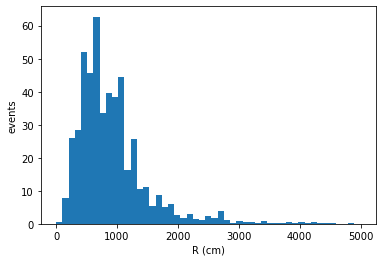

In [600]:
df = final_dfs[2]
_ = plt.hist(np.sqrt(df['pos_decay','1']**2+df['pos_decay','2']**2+df['pos_decay','3']**2), weights=df['reco_w'], bins=np.linspace(0,5000))
# _ = plt.hist(df['pos_scatt','3'], weights=df['w_event_rate'], bins=100)

plt.xlabel("R (cm)")
plt.ylabel("events")

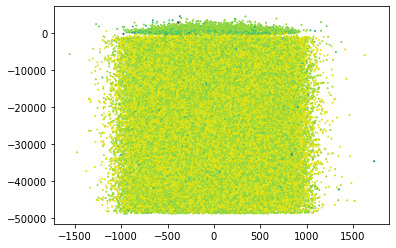

In [543]:
plt.scatter(df['pos_decay','2'], df['pos_decay','3'], s=1, c=np.log10(df['w_pre_decay']))

In [548]:
df['reco_w'][df['pos_scatt','3']>-600].sum()

268.4263480539959

In [587]:
ht

(array([3.65811303e+02, 1.40030792e+02, 5.50011312e+01, 2.26300425e+01,
        1.02987393e+01, 6.91001963e+00, 3.17288805e+00, 1.69639376e+00,
        1.01289679e+00, 3.21703125e-01, 8.98284087e-02, 1.77414675e+00,
        5.18407426e-05, 3.73556827e-06, 0.00000000e+00, 2.80326973e-02,
        0.00000000e+00, 7.94980531e-02, 0.00000000e+00]),
 array([  0.        ,   5.26315789,  10.52631579,  15.78947368,
         21.05263158,  26.31578947,  31.57894737,  36.84210526,
         42.10526316,  47.36842105,  52.63157895,  57.89473684,
         63.15789474,  68.42105263,  73.68421053,  78.94736842,
         84.21052632,  89.47368421,  94.73684211, 100.        ]),
 [<matplotlib.patches.Polygon at 0x7fc075c62c40>])

(0.0, 115.0821224054364)

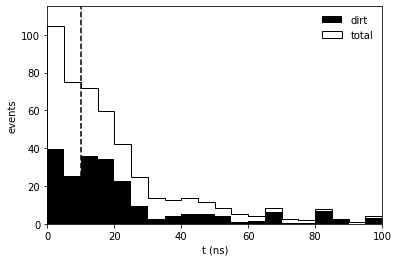

In [597]:
df = final_dfs[2]
dirt_mask = (df['pos_scatt','3']<-610)
tmax = 100
_ = plt.hist(df['pos_decay','0'][dirt_mask]*1e9, weights=df['reco_w'][dirt_mask], bins=np.linspace(0,tmax, 21), histtype='bar', color='black',
            label='dirt')
ht,_,_ = plt.hist(df['pos_decay','0']*1e9, weights=df['reco_w'], bins=np.linspace(0,tmax, 21), histtype='step', color='black',
            label='total')

plt.vlines(10,0,1e3, colors='black', ls='--')
plt.legend(loc='upper right', frameon=False)
plt.xlabel("t (ns)")
plt.ylabel("events")
plt.xlim(0,tmax)
plt.ylim(0,ht[0]*1.1)



Benchmark 1: transition mag moment
ctau0 = 2.43715 cm
Raw events at MiniBooNE: 3.7e+06 total (1.9e+06 coh : 1.9e+06 pel : 0 nel)
Selected events at MiniBooNE: 5.8e+02 total (2.1e+02 coh : 3.7e+02 pel : 0 nel)
MiniBooNE p-value: 0.4990285908014376
Raw events at MicroBooNE: 4.1e+06 total (2e+06 coh : 2.1e+06 pel : 0 nel)

Benchmark 2: mzprime = 0.03, mhprime = None
2.5368368487318902e-12
Raw events at MiniBooNE: 9.8e+06 total (8.8e+06 coh : 9.8e+05 pel : 0 nel)
Selected events at MiniBooNE: 5.8e+02 total (4.7e+02 coh : 1.1e+02 pel : 0 nel)
MiniBooNE p-value: 0.5246846900631348
Raw events at MicroBooNE: 1.1e+07 total (9.7e+06 coh : 1.1e+06 pel : 0 nel)

Benchmark 3: mzprime = 1.25, mhprime = None
91.59537921009647
Raw events at MiniBooNE: 7.5e+06 total (3.2e+06 coh : 4.3e+06 pel : 0 nel)
Selected events at MiniBooNE: 4.9e+02 total (1.8e+02 coh : 3.2e+02 pel : 0 nel)
MiniBooNE p-value: 0.5784161287535086
Raw events at MicroBooNE: 8.2e+06 total (3.6e+06 coh : 4.7e+06 pel : 0 nel)

Benchmar

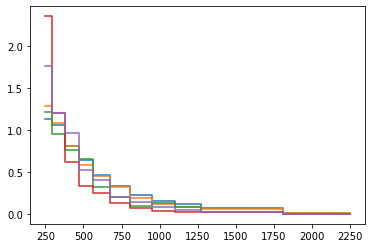

In [601]:
for i, (df, df_mub) in enumerate(zip(final_dfs,final_dfs_muB)):
    if i>0:
        print(f'\nBenchmark {i+1}: mzprime = {df.attrs["model"].mzprime}, mhprime = {df.attrs["model"].mhprime}')
        print(f"{df.attrs['N5_ctau0']}")

    else:
        print(f'\nBenchmark {i+1}: transition mag moment')
        print(f"ctau0 = {df.attrs['N4_ctau0']:2g} cm")

    print_summary_of_event(df, col='w_pre_decay',summary='Raw events at MiniBooNE')
    print_summary_of_event(df, col='reco_w', summary='Selected events at MiniBooNE')
    print(f'MiniBooNE p-value: {get_pval(df)}')
    print_summary_of_event(df_mub, col='w_pre_decay',summary='Raw events at MicroBooNE')

#### Light Scalar benchmark

Initializing the three-portal model.
---------------------------------------------------------
   ______           _        _   _                     
   |  _  \         | |      | \ | |                    
   | | | |__ _ _ __| | __   |  \| | _____      _____   
   | | | / _  | ___| |/ /   | .   |/ _ \ \ /\ / / __|  
   | |/ / (_| | |  |   <    | |\  |  __/\ V  V /\__ \  
   |___/ \__,_|_|  |_|\_\   \_| \_/\___| \_/\_/ |___/  

---------------------------------------------------------
Model:
	2 dirac heavy neutrino(s).

---------------------------------------------------------
Experiment:
	MiniBooNE_FHC
	fluxfile loaded: MiniBooNE_FHC.dat
	POT: 1.875e+21
	nuclear targets: ['C12', 'H1']
	fiducial mass: [701.1428571428571, 116.85714285714286] tonnes

Directory tree for this run already exists. Overriding it.
---------------------------------------------------------
Generating Events using the neutrino-nucleus upscattering engine

nu(mu) C12 --> N5  C12 --> N4 e+ e- C12
Helicity conservin

/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/model.py:580: RuntimeWarning: invalid value encountered in sqrt
  self.le_state_norms = np.sqrt(1 - np.sum((self.Ulep.conjugate()*self.Ulep)[:,3:], axis=1))


Parent N5 proper decay length: 2.536E-12 cm.

Predicted (1.06e+04 +/- 127) events.

nu(mu) C12 --> N5  C12 --> N4 e+ e- C12
Helicity flipping upscattering.
N5 decays via on-shell Z'.
Parent N5 proper decay length: 2.537E-12 cm.

Predicted (1.21 +/- 0.0148) events.

nu(mu) proton_in_C12 --> N5  proton_in_C12 --> N4 e+ e- proton_in_C12
Helicity conserving upscattering.
N5 decays via on-shell Z'.
Parent N5 proper decay length: 2.537E-12 cm.

Predicted (2.02e+03 +/- 24.2) events.

nu(mu) proton_in_C12 --> N5  proton_in_C12 --> N4 e+ e- proton_in_C12
Helicity flipping upscattering.
N5 decays via on-shell Z'.
Parent N5 proper decay length: 2.536E-12 cm.

Predicted (1.31 +/- 0.0151) events.

nu(mu) proton_in_H1 --> N5  proton_in_H1 --> N4 e+ e- proton_in_H1
Helicity conserving upscattering.
N5 decays via on-shell Z'.
Parent N5 proper decay length: 2.536E-12 cm.

Predicted (668 +/- 8.06) events.

nu(mu) proton_in_H1 --> N5  proton_in_H1 --> N4 e+ e- proton_in_H1
Helicity flipping upscattering.

MB events: 5.6e+02


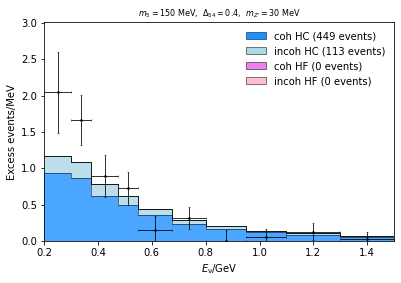

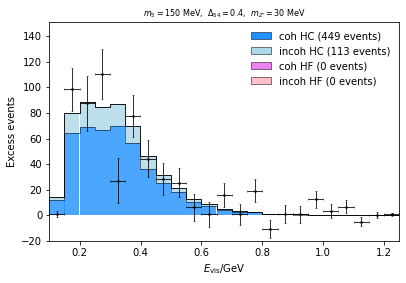

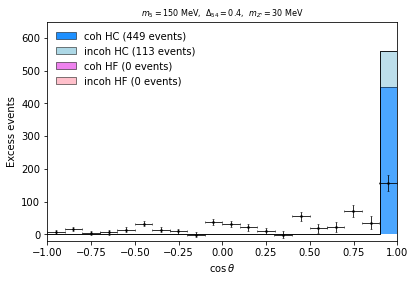

In [32]:
MBplotter(df, 'BP light vector', title='$m_5 = 150$ MeV,  $\Delta_{54} = 0.4$,  $m_{Z^\prime} = 30$ MeV')

0.5386478827603424

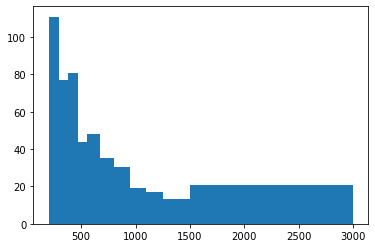

In [35]:
get_pval(df_prob)

# Heavy Z' point

Initializing the three-portal model.
---------------------------------------------------------
   ______           _        _   _                     
   |  _  \         | |      | \ | |                    
   | | | |__ _ _ __| | __   |  \| | _____      _____   
   | | | / _  | ___| |/ /   | .   |/ _ \ \ /\ / / __|  
   | |/ / (_| | |  |   <    | |\  |  __/\ V  V /\__ \  
   |___/ \__,_|_|  |_|\_\   \_| \_/\___| \_/\_/ |___/  

---------------------------------------------------------
Model:
	2 dirac heavy neutrino(s).

---------------------------------------------------------
Experiment:
	MiniBooNE_FHC
	fluxfile loaded: MiniBooNE_FHC.dat
	POT: 1.875e+21
	nuclear targets: ['C12', 'H1']
	fiducial mass: [701.1428571428571, 116.85714285714286] tonnes

Directory tree for this run already exists. Overriding it.
---------------------------------------------------------
Generating Events using the neutrino-nucleus upscattering engine

nu(mu) C12 --> N5  C12 --> N4 e+ e- C12
Helicity conservin

/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/model.py:580: RuntimeWarning: invalid value encountered in sqrt
  self.le_state_norms = np.sqrt(1 - np.sum((self.Ulep.conjugate()*self.Ulep)[:,3:], axis=1))


Parent N5 proper decay length: 9.171E+01 cm.

Predicted (5.33e+03 +/- 63.4) events.

nu(mu) C12 --> N5  C12 --> N4 e+ e- C12
Helicity flipping upscattering.
N5 three-body decays.
Parent N5 proper decay length: 9.123E+01 cm.

Predicted (10.2 +/- 0.123) events.

nu(mu) proton_in_C12 --> N5  proton_in_C12 --> N4 e+ e- proton_in_C12
Helicity conserving upscattering.
N5 three-body decays.
Parent N5 proper decay length: 9.143E+01 cm.

Predicted (8.74e+03 +/- 103) events.

nu(mu) proton_in_C12 --> N5  proton_in_C12 --> N4 e+ e- proton_in_C12
Helicity flipping upscattering.
N5 three-body decays.
Parent N5 proper decay length: 9.167E+01 cm.

Predicted (68.8 +/- 0.81) events.

nu(mu) proton_in_H1 --> N5  proton_in_H1 --> N4 e+ e- proton_in_H1
Helicity conserving upscattering.
N5 three-body decays.
Parent N5 proper decay length: 9.157E+01 cm.

Predicted (2.9e+03 +/- 34.1) events.

nu(mu) proton_in_H1 --> N5  proton_in_H1 --> N4 e+ e- proton_in_H1
Helicity flipping upscattering.
N5 three-body deca

552.3021644044011
0.7207190182739094


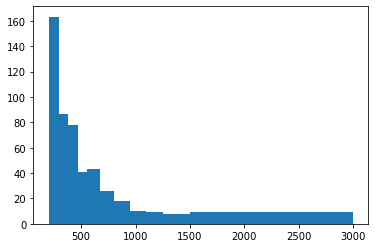

In [41]:
df_prob = ad.select_MB_decay_expo_prob(an.compute_spectrum(df, EVENT_TYPE='both'))
print(df_prob['reco_w'].sum())
print(get_pval(df_prob))

MB events: 5.5e+02


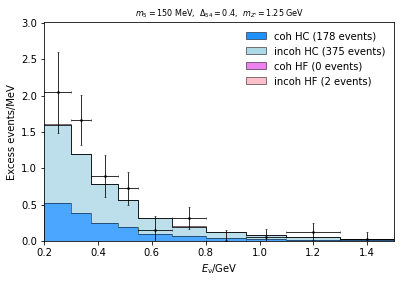

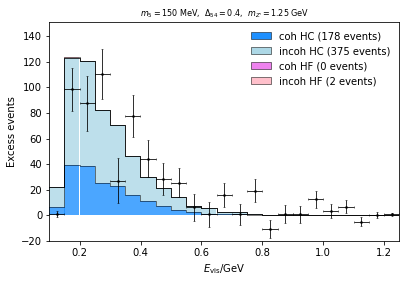

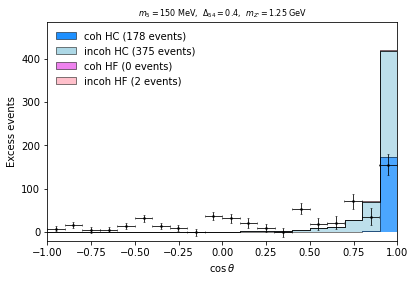

In [38]:
MBplotter(df, 'BP heavy vector', title='$m_5 = 150$ MeV,  $\Delta_{54} = 0.4$,  $m_{Z^\prime} = 1.25$ GeV')

# Scalar heavy benchmark

517.3465813534124
0.5388200226802871


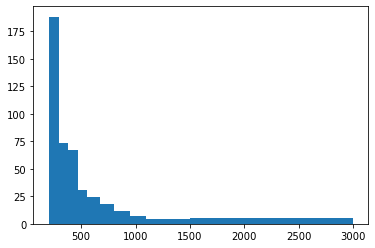

In [45]:
df_prob = ad.select_MB_decay_expo_prob(an.compute_spectrum(df, EVENT_TYPE='both'))
print(df_prob['reco_w'].sum())
print(get_pval(df_prob))

MB events: 5.2e+02


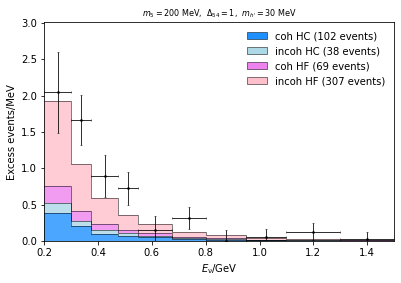

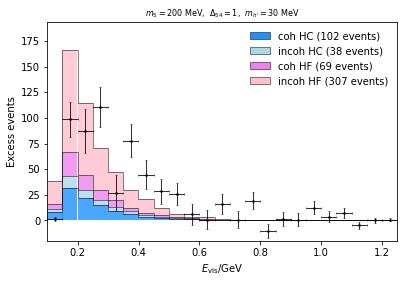

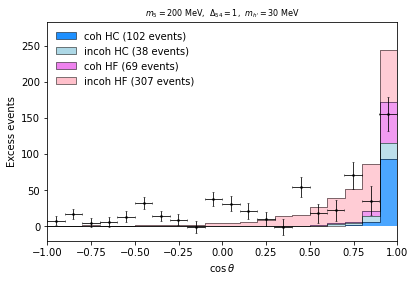

In [44]:
MBplotter(df, 'BP light scalar', title='$m_5 = 200$ MeV,  $\Delta_{54} = 1$,  $m_{h^\prime} = 30$ MeV')

559.7951443727101
0.49133932483166165


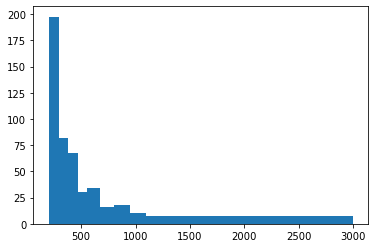

In [47]:
df_prob = ad.select_MB_decay_expo_prob(an.compute_spectrum(df, EVENT_TYPE='both'))
print(df_prob['reco_w'].sum())
print(get_pval(df_prob))

MB events: 5.5e+02


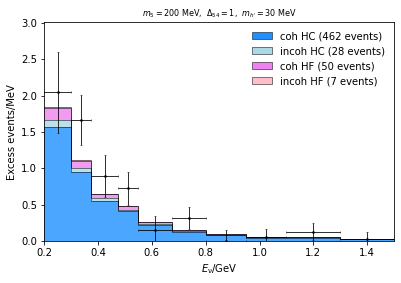

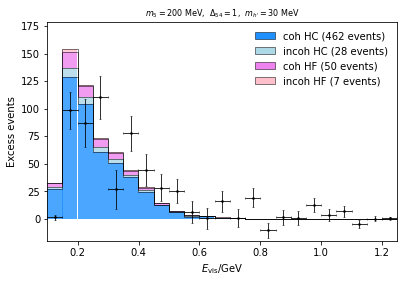

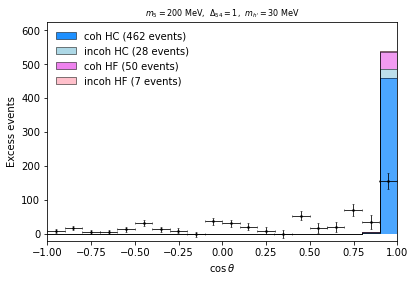

In [48]:
MBplotter(df, 'BP light scalar', title='$m_5 = 200$ MeV,  $\Delta_{54} = 1$,  $m_{h^\prime} = 30$ MeV')

In [19]:
df.attrs['model'].__dict__.

{'model_file': None,
 'name': 'my_model',
 'm4': 0.1,
 'm5': 0.2,
 'm6': None,
 'HNLtype': 'dirac',
 'mzprime': 0.05,
 'mhprime': 0.05,
 'mu_tr_e4': 0.0,
 'mu_tr_e5': 0.0,
 'mu_tr_e6': 0.0,
 'mu_tr_mu4': 0.0,
 'mu_tr_mu5': 0.0,
 'mu_tr_mu6': 0.0,
 'mu_tr_tau4': 0.0,
 'mu_tr_tau5': 0.0,
 'mu_tr_tau6': 0.0,
 'mu_tr_44': 0.0,
 'mu_tr_45': 0.0,
 'mu_tr_46': 0.0,
 'mu_tr_55': 0.0,
 'mu_tr_56': 0.0,
 'mu_tr_66': 0.0,
 's_e4': 0.0,
 's_e5': 0.0,
 's_e6': 0.0,
 's_mu4': 0.0,
 's_mu5': 0.001,
 's_mu6': 0.0,
 's_tau4': 0.0,
 's_tau5': 0.0,
 's_tau6': 0.0,
 's_44': 0.0,
 's_45': 1.0,
 's_46': 0.0,
 's_55': 0.0,
 's_56': 0.0,
 's_66': 0.0,
 'cprotonV': 0.0,
 'cprotonA': 0.0,
 'cneutronV': 0.0,
 'cneutronA': 0.0,
 'dprotonV': 0.0,
 'dprotonA': 0.0,
 'dneutronV': 0.0,
 'dneutronA': 0.0,
 'dSproton': None,
 'dSneutron': None,
 'dPproton': None,
 'dPneutron': None,
 'model_params': {'m4': 0.1,
  'm5': 0.2,
  'mzprime': 0.05,
  'mhprime': 0.05,
  'HNLtype': 'dirac',
  's_mu5': 0.001,
  's_45': 1.0,
  '

In [151]:
MODEL_KWARGS = {'HNLtype': 'majorana', 'UD4': 1.0, 'alphaD': 0.25, 'Umu4': np.sqrt(9e-7), 'epsilon': np.sqrt(2e-10/const.alphaQED)}


# gen = GenLauncher(mu_tr_mu4=1e-6, m4=0.5, epsilon=0.0, gD=0.0, decay_product='e+e-', Umu4=0.0,
#                     neval=1000, experiment="miniboone_fhc", loglevel='info', seed=42)
gen = GenLauncher(noHF=True, nocoh=True)
df = gen.run()


Initializing the three-portal model.
---------------------------------------------------------
   ______           _        _   _                     
   |  _  \         | |      | \ | |                    
   | | | |__ _ _ __| | __   |  \| | _____      _____   
   | | | / _  | ___| |/ /   | .   |/ _ \ \ /\ / / __|  
   | |/ / (_| | |  |   <    | |\  |  __/\ V  V /\__ \  
   |___/ \__,_|_|  |_|\_\   \_| \_/\___| \_/\_/ |___/  

---------------------------------------------------------
Model:
	1 dirac heavy neutrino(s).

---------------------------------------------------------
Experiment:
	MiniBooNE_FHC
	fluxfile loaded: MiniBooNE_FHC.dat
	POT: 1.875e+21
	nuclear targets: ['C12', 'H1']
	fiducial mass: [701.1428571428571, 116.85714285714286] tonnes

Directory tree for this run already exists. Overriding it.
---------------------------------------------------------
Generating Events using the neutrino-nucleus upscattering engine

nu(mu) proton_in_C12 --> N4  proton_in_C12 --> nu_light e+

In [152]:
df.columns

MultiIndex([(      'P_projectile', '0'),
            (      'P_projectile', '1'),
            (      'P_projectile', '2'),
            (      'P_projectile', '3'),
            (          'P_target', '0'),
            (          'P_target', '1'),
            (          'P_target', '2'),
            (          'P_target', '3'),
            (          'P_recoil', '0'),
            (          'P_recoil', '1'),
            (          'P_recoil', '2'),
            (          'P_recoil', '3'),
            (  'P_decay_N_parent', '0'),
            (  'P_decay_N_parent', '1'),
            (  'P_decay_N_parent', '2'),
            (  'P_decay_N_parent', '3'),
            ( 'P_decay_ell_minus', '0'),
            ( 'P_decay_ell_minus', '1'),
            ( 'P_decay_ell_minus', '2'),
            ( 'P_decay_ell_minus', '3'),
            (  'P_decay_ell_plus', '0'),
            (  'P_decay_ell_plus', '1'),
            (  'P_decay_ell_plus', '2'),
            (  'P_decay_ell_plus', '3'),
            ('P_

In [153]:
P_proj_CM[:,2]

array([0., 0., 0., ..., 0., 0., 0.])

(array([1.64577526e-04, 0.00000000e+00, 0.00000000e+00, 2.51611539e-04,
        0.00000000e+00, 0.00000000e+00, 2.67471477e-03, 0.00000000e+00,
        0.00000000e+00, 1.51922289e-03, 1.74806014e-03, 1.28511130e-02,
        7.12167507e-03, 1.36456778e-02, 6.58886075e-02, 1.32556524e-01,
        3.88559383e+01, 1.21817801e+01, 1.67905741e-01, 2.96993374e-02,
        1.21022611e-02, 1.92306581e-02, 1.17726038e-02, 4.92197621e-03,
        0.00000000e+00, 1.81553463e-04, 0.00000000e+00, 0.00000000e+00,
        7.31414400e-04, 0.00000000e+00, 1.34731820e-04, 0.00000000e+00,
        0.00000000e+00, 2.80884064e-04, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.18732447e-06,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.000000

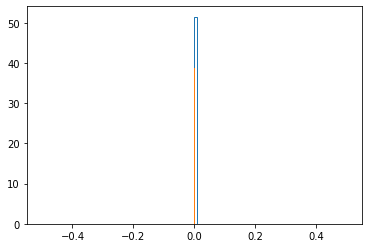

In [155]:
M = df['P_target','0']
s = M**2 + 2*M*df['P_projectile','0']
E2CM = (s + M ** 2) / 2.0 / np.sqrt(s)
p2CM = np.sqrt(E2CM ** 2 - M ** 2)
beta = (-p2CM / E2CM).to_numpy()

P_recoil_CM = Cfv.L(df['P_recoil'].to_numpy(), -beta)
P_target_CM = Cfv.L(df['P_target'].to_numpy(), -beta)
P_proj_CM = Cfv.L(df['P_projectile'].to_numpy(), -beta)
P_N_CM = Cfv.L(df['P_decay_N_parent'].to_numpy(), -beta)

plt.hist(P_target_CM[:,1]+P_proj_CM[:,1], weights = df['w_event_rate'], histtype='step', bins=100)
plt.hist(P_recoil_CM[:,1]+P_N_CM[:,1], weights = df['w_event_rate'], histtype='step', bins=100)


(array([8.41309141e-06, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 3.10794261e-06, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.41841579e-05, 6.86537397e-06,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 4.61428318e-05, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 4.84177605e-05, 0.00000000e+00, 1.37661409e-04,
        0.00000000e+00, 0.00000000e+00, 4.75091275e-05, 5.30574696e-05,
        0.00000000e+00, 2.39342180e-04, 7.25787542e-05, 1.46136644e-04,
        1.00283052e-04, 1.35155572e-04, 8.32596369e-04, 1.51152232e-03,
        6.40811209e-04, 3.28956337e-03, 5.50242778e-03, 3.979389

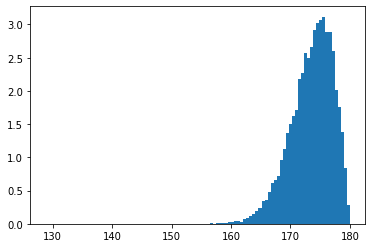

In [161]:
plt.hist( np.arccos(Cfv.get_cosTheta(Cfv.L(P_recoil_CM, *beta/beta)))*180/np.pi, bins=100, weights=df['w_event_rate'])


(array([33.98880313,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

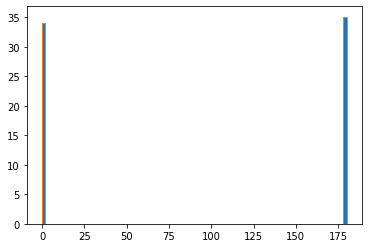

In [104]:
import DarkNews.fourvec as fv
plt.hist( np.arccos(Cfv.get_cosTheta(df['P_target'].to_numpy()))*180/np.pi, bins=100, weights=df['w_event_rate'])
plt.hist( np.arccos(fv.df_cos_azimuthal(df['P_target']))*180/np.pi, histtype='step', bins=100, weights=df['w_event_rate'])

In [6]:
MODEL_KWARGS = {'HNLtype': 'dirac', 'UD4': 1.0, 'alphaD': 0.25, 'Umu4': np.sqrt(9e-7), 'epsilon': np.sqrt(2e-10/const.alphaQED)}

gen = GenLauncher(mzprime=0.03, m4=0.420, neval=1000, nu_flavors=['nu_mu','nu_e','nu_mu_bar'], experiment="miniboone_fhc", loglevel='warning', seed=42, numpy=True, parquet=True, sparse=True, **MODEL_KWARGS)
df=gen.run(loglevel="warning")

ValueError: Parameter 'nu_flavors', invalid choice: ['nu_mu', 'nu_e', 'nu_mu_bar'], (choose among nu_e, nu_mu, nu_tau, nu_e_bar, nu_mu_bar, nu_tau_bar)

In [5]:
df['h_projectile']

0      -1
1      -1
2      -1
3      -1
4      -1
       ..
5587    1
5588    1
5589    1
5590    1
5591    1
Name: h_parent, Length: 5592, dtype: int64

In [22]:
gen_path = df.attrs['data_path']
df_pq = pd.read_parquet(Path(f"{gen_path}/pandas_df.parquet"), engine='pyarrow')
# df_pq = pd.read_pickle(Path(f"{gen_path}/pandas_df.pckl"))
nda = np.load(Path(f"{gen_path}/ndarray.npy"))


In [23]:
df_pandas = df_pq
# helicity only present in sparse format
if 'helicity' in df_pandas.columns.levels[0]:
    # test that numpy array and dataframe formats save the same information
    df_pandas = df_pandas.replace(to_replace='conserving', value= '+1')
    df_pandas = df_pandas.replace(to_replace='flipping',   value= '-1')

# remove non-numeric entries
drop_list = ['underlying_process','target','scattering_regime']
if not set(drop_list).isdisjoint(df_pandas.columns.levels[0]):
    df_for_numpy = df_pandas.drop([col for col in drop_list if col in df_pandas.columns.levels[0]], axis=1, level=0).to_numpy(dtype=np.float64) 
else:
    df_for_numpy = df_pandas.to_numpy(dtype=np.float64)  
assert (df_for_numpy[nda!=0]/nda[nda!=0]!=1).sum() == 0, 'pandas dataframe and numpy array seem to contain different data.'


In [89]:


drop_list = ['underlying_process','target','scattering_regime']

if not set(drop_list).isdisjoint(df_pq.columns.levels[0]):
    df_for_numpy = df_pq.drop([col for col in drop_list if col in df_pq.columns.levels[0]], axis=1, level=0).to_numpy(dtype=np.float64)
else:
    df_for_numpy = df_pq.to_numpy(dtype=np.float64)
df_for_numpy

array([[ 9.17188653e-01,  9.16124727e-01,  1.59980230e-02, ...,
         3.73399539e-06,  2.01213964e-15,  1.38903642e+01],
       [ 1.37667063e+00,  1.37617485e+00,  2.59185364e-02, ...,
         2.16799358e-06,  3.58706846e-15,  8.95753095e+00],
       [ 1.29687705e+00,  1.29584745e+00, -2.41520320e-02, ...,
         3.18334345e-06,  1.75033740e-15,  1.16851308e+01],
       ...,
       [ 8.43364289e-01,  8.40950749e-01,  1.11306121e-01, ...,
         1.15874669e-06,  1.12970402e-15,  2.67871672e-04],
       [ 1.09838309e+00,  1.05749783e+00, -2.30827745e-01, ...,
         1.26884935e-06,  8.97558554e-16,  2.66636955e-03],
       [ 6.74185894e-01,  6.71551468e-01, -1.37383525e-01, ...,
         1.11720019e-06,  6.00265885e-16,  2.48204550e-04]])

In [45]:
 df_for_numpy = df_pq.drop(,axis=1, level=0)

SyntaxError: invalid syntax (<ipython-input-45-43c5b9fc6e2a>, line 1)

In [6]:
import vegas 
import gvar
gvar.__version__

'11.10'

In [14]:
from DarkNews import fourvec as fv

In [14]:
gen = GenLauncher(mzprime=0.03, m4=0.420, epsilon=epsilon_def, Umu4=umu4_def, UD4=ud4_def, gD=gD_def, 
                    neval=1000, HNLtype="dirac", experiment="miniboone_fhc", loglevel='INFO',
                    seed=333,
                    parquet=True, numpy=True, hepevt=True, sparse=True, print_to_float32=True)

df=gen.run(loglevel="ERROR")
df_2=gen.run(loglevel="ERROR")

Initializing the three-portal model.
---------------------------------------------------------
   ______           _        _   _                     
   |  _  \         | |      | \ | |                    
   | | | |__ _ _ __| | __   |  \| | _____      _____   
   | | | / _  | ___| |/ /   | .   |/ _ \ \ /\ / / __|  
   | |/ / (_| | |  |   <    | |\  |  __/\ V  V /\__ \  
   |___/ \__,_|_|  |_|\_\   \_| \_/\___| \_/\_/ |___/  

---------------------------------------------------------
Model:
	1 dirac heavy neutrino(s).

---------------------------------------------------------
Experiment:
	MiniBooNE_FHC
	fluxfile loaded: ../fluxes/MiniBooNE_FHC.dat
	POT: 1.875e+21
	nuclear targets: ['C12', 'H1']
	fiducial mass: [701.1428571428571, 116.85714285714286] tonnes

Directory tree for this run already exists. Overriding it.


In [ ]:
new_c(df)

In [ ]:
%prun 

gen.dn_printer.print_events_to_HEPEVT()

In [ ]:
filename="./data/miniboone_fhc/3plus1/m4_0.42_mzprime_0.03_dirac/"

df_std = pd.read_pickle(f"{filename}pandas_df.pckl")
df_pq = pd.read_parquet(f"{filename}pandas_df.parquet", engine='pyarrow')
nda = np.load(f"{filename}ndarray.npy")
# ndz = np.load(f"{filename}ndarray.npz")


In [ ]:
nda_fix=np.reshape(nda,(np.shape(nda)[0],int(np.shape(nda)[1]/4),4)).T



### npz format tests

In [ ]:
cols = [f'{v[0]}_{v[1]}' if v[1] else f'{v[0]}' for v in df.columns.values]
print(cols)

In [ ]:
# test that numpy array and dataframe formats save the same information
assert (df_std.to_numpy()[nda!=0]/nda[nda!=0]!=1).sum() == 0 
assert (df_pq.to_numpy()[nda!=0]/nda[nda!=0]!=1).sum() == 0

In [ ]:
if 'as':
    print("Error")

# Vegas tests

In [4]:
# Testing the VEGAS integration methods:
import vegas as vg
from collections import OrderedDict

class test_integral(vg.BatchIntegrand):

    def __init__(self, dim, c = 1):
        self.dim = dim	
        self.c = c
        self.analytical_func = lambda x: np.exp(self.c * x) * (self.c*x-1)/self.c**2
        self.analytical_res  = (self.analytical_func(2) - self.analytical_func(0))

        # initialize
        self.norm = {'diff_xsec': 1, 'diff_xsec2': 1}
        # normalize integrand with an initial throw
        _throw = self.__call__(np.random.rand(dim,500), np.ones((dim,500)))
        for key,val in _throw.items():
            self.norm[key] = np.mean(val)
    
    def __call__(self, x, jac):

        xmax = 2
        xmin = 0
        xx=np.empty(0)
        diff = 1
        diff2 = 1
        for d in range(self.dim):
            xx = x[:,d]*(xmax - xmin) + xmin
            diff *= np.exp(self.c*xx)*xx
            if d < self.dim - 2:
                diff2 *= np.exp(self.c*xx)*xx

        # hypercube jacobian (vegas hypercube --> physical limits) transformation
        hypercube_jacobian = (xmax - xmin)
        diff  *= hypercube_jacobian**self.dim
        diff2 *= hypercube_jacobian**(self.dim)

        ##############################################
        # return all differential quantities of interest
        self.int_dic = OrderedDict()		
        self.int_dic['diff_xsec'] = diff
        self.int_dic['diff_xsec2'] = diff2
        
        ##############################################
        # storing normalization for integrands to be of O(1) numbers		
        # normalization
        for key in self.int_dic:
            self.int_dic[key] /= self.norm[key]
        self.int_dic['diff_xsec2'] /= jac[:,-1]*jac[:,-2]
        return self.int_dic

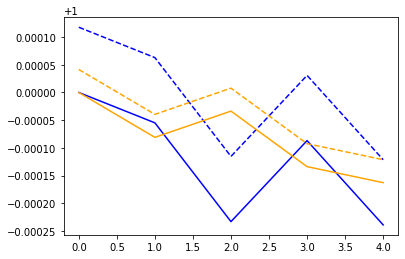

In [5]:
evals = []
evals2 = []
for i in range(5):
    #########################################################################
    # BATCH SAMPLE INTEGRAND OF INTEREST
    DIM = 6
    batch_f = test_integral(dim=DIM)
    integ = vg.Integrator(DIM*[[0.0, 1.0]]) # unit hypercube
    result = dn.MC.run_vegas(batch_f, integ, NINT=20, NEVAL=10000, NINT_warmup=20, NEVAL_warmup=1000)
    ##########################################################################
    # print(result.summary())
    evals.append(result['diff_xsec'].mean*batch_f.norm['diff_xsec'])
    evals2.append(result['diff_xsec2'].mean*batch_f.norm['diff_xsec2'])

plt.plot(evals/evals[0], color='blue')
plt.plot(evals/batch_f.analytical_res**DIM, ls='--', color='blue')
plt.plot(evals2/evals2[0], color='orange')
plt.plot(evals2/batch_f.analytical_res**(DIM-2)/4, ls='--', color='orange')


In [6]:
samples, weights, jac = dn.MC.get_samples(integ, batch_f, return_jac=True)

In [7]:
np.sum(weights['diff_xsec'])*batch_f.norm['diff_xsec']/batch_f.analytical_res**DIM


1.0003406373054546

In [8]:
np.sum(weights['diff_xsec'])*batch_f.norm['diff_xsec']/batch_f.analytical_res**(DIM)


1.0003406373054546

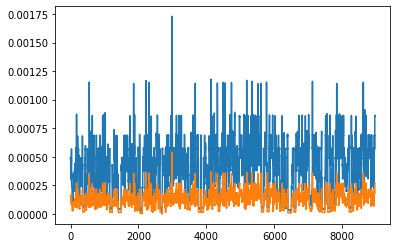

In [9]:
for key,vals in weights.items():
    plt.plot(vals)

In [10]:
(weights['diff_xsec2']*jac[:,5]).sum()


1.043775559346706

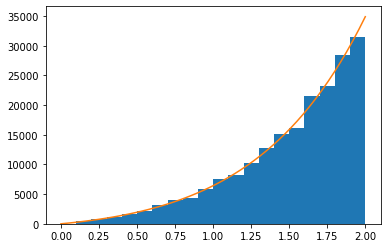

In [11]:
bins = 20

_ = plt.hist(samples[0,:]*2, weights=weights['diff_xsec2']*batch_f.norm['diff_xsec2']/(2/bins), bins=bins, density=False)

x=np.linspace(0,2)

plt.plot(x, np.exp(batch_f.c * x)*x * batch_f.analytical_res**(DIM-3)*4)


## Test propagator integral in vegas 

In [23]:
class prop_integral(vg.BatchIntegrand):

    def __init__(self, dim, m, Gamma):
        self.dim = dim	
        self.Gamma = Gamma
        self.m = m

        # initialize
        self.norm = {'diff_xsec': 1, 'diff_xsec2': 1}
        # normalize integrand with an initial throw
        _throw = self.__call__(np.random.rand(dim,500), np.ones((dim,500)))
        for key,val in _throw.items():
            self.norm[key] = np.mean(val)
    
    def __call__(self, x, jac):

        xmax = 2
        xmin = 0
        xx=np.empty(0)

        diff = 1/((x**2-self.m**2)**2 + (self.m*self.Gamma)**2)
        diff2 = 1

        # hypercube jacobian (vegas hypercube --> physical limits) transformation
        hypercube_jacobian = (xmax - xmin)
        diff  *= hypercube_jacobian**self.dim
        diff2 *= hypercube_jacobian**(self.dim)

        ##############################################
        # return all differential quantities of interest
        self.int_dic = OrderedDict()		
        self.int_dic['diff_xsec'] = diff
        self.int_dic['diff_xsec2'] = diff2
        
        ##############################################
        # storing normalization for integrands to be of O(1) numbers		
        # normalization
        for key in self.int_dic:
            self.int_dic[key] /= self.norm[key]
        self.int_dic['diff_xsec2'] /= jac[:,-1]
        
        return self.int_dic

In [25]:
mzprime = 0.03
Gamma = mzprime/3*1e-8

DIM = 1
batch_f = prop_integral(dim=DIM, m = mzprime, Gamma=Gamma)
integ = vg.Integrator(DIM*[[0.0, 1.0]]) # unit hypercube
result = dn.MC.run_vegas(batch_f, integ, NINT=20, NEVAL=10000, NINT_warmup=20, NEVAL_warmup=1000)
##########################################################################
print(result.summary())


itn   integral         wgt average      chi2/dof        Q
---------------------------------------------------------
  1   1.10894(23)e+07  1.10894(23)e+07      0.00     1.00
  2   1.10873(13)e+07  1.10878(11)e+07      0.31     0.73
  3   1.10899(14)e+07  1.108862(89)e+07     0.50     0.74
  4   1.10892(12)e+07  1.108880(71)e+07     0.35     0.91
  5   1.10905(12)e+07  1.108928(61)e+07     0.47     0.88
  6   1.108572(76)e+07 1.108788(47)e+07     1.72     0.07
  7   1.108198(71)e+07 1.108608(40)e+07     5.38     0.00
  8   1.10770(13)e+07  1.108534(38)e+07     7.69     0.00
  9   1.107368(90)e+07 1.108358(35)e+07    15.66     0.00
 10   1.10744(38)e+07  1.108350(35)e+07    14.24     0.00
 11   1.10669(26)e+07  1.108322(34)e+07    14.78     0.00
 12   1.1078(14)e+07   1.108321(34)e+07    13.44     0.00
 13   1.10593(35)e+07  1.108298(34)e+07    14.30     0.00
 14   1.1169(84)e+07   1.108298(34)e+07    13.24     0.00
 15   1.1101(28)e+07   1.108298(34)e+07    12.31     0.00
 16   1.10985(

In [24]:
mzprime = 0.03
Gamma = mzprime/3*1e-8

evals = []
evals2 = []
for i in range(5):
    #########################################################################
    # BATCH SAMPLE INTEGRAND OF INTEREST
    DIM = 1
    batch_f = prop_integral(dim=DIM, m = mzprime, Gamma=Gamma)
    integ = vg.Integrator(DIM*[[0.0, 1.0]]) # unit hypercube
    result = dn.MC.run_vegas(batch_f, integ, NINT=20, NEVAL=10000, NINT_warmup=20, NEVAL_warmup=1000)
    ##########################################################################
    # print(result.summary())
    evals.append(result['diff_xsec'].mean*batch_f.norm['diff_xsec'])
    evals2.append(result['diff_xsec2'].mean*batch_f.norm['diff_xsec2'])

plt.plot(evals/evals[0], color='blue')
plt.plot(evals/batch_f.analytical_res**DIM, ls='--', color='blue')
plt.plot(evals2/evals2[0], color='orange')
plt.plot(evals2/batch_f.analytical_res**(DIM-2)/4, ls='--', color='orange')


TypeError: unsupported operand type(s) for *: 'builtin_function_or_method' and 'float'

# profile amplitude calculation

In [ ]:
proton = dn.detector.NuclearTarget("H1")
bsm_model = dn.model.create_3portal_HNL_model(mzprime=0.1, m4 = 0.01, Umu4=1e-3)
calculator = dn.MC.XsecCalc(bsm_model = bsm_model, scattering_regime = 'p-el', nuclear_target= proton, helicity = 'conserving')

In [ ]:
one = np.ones(1000)
%prun dn.amplitudes.upscattering_dxsec_dQ2([one,one,one], calculator.ups_case)

# profile full generation

In [ ]:
ud4_def = 1.0
alphaD = 0.25
gD_def = np.sqrt(alphaD*4*np.pi)
umu4_def = np.sqrt(9e-7)
ud4 = 1.
epsilon_def = np.sqrt(2e-10/const.alphaQED)

gen = GenLauncher(mzprime=0.03, m4=0.420, epsilon=epsilon_def, Umu4=umu4_def, UD4=ud4_def, gD=gD_def, neval=1000, HNLtype="dirac", experiment="miniboone_fhc", loglevel='INFO')
gen.run(log="INFO")
df_mini = gen.df

In [ ]:
%prun gen.run(log="ERROR")

In [ ]:
df_mini.w_event_rate.sum()*0.05


In [ ]:
gen = GenLauncher(mzprime=0.03, m4=0.420, epsilon=epsilon_def, Umu4=umu4_def, UD4=ud4_def, gD=gD_def, neval=1000, HNLtype="dirac", experiment="microboone", loglevel='ERROR')
gen.run(log="ERROR")
df_micro = gen.df

In [ ]:
ud4_def = 1.0
alphaD = 0.4
gD_def = np.sqrt(alphaD*4*np.pi)
umu4_def = 4e-4
umu5_def = 4e-4
ud4 = 1.
ud5 = 1.
epsilon_def = 2.2e-2

gen = GenLauncher(mzprime=1.25, m4=0.010, m5=0.490, epsilon=epsilon_def, Umu4=umu4_def, Umu5=umu5_def, UD4=ud4_def, UD5=ud5, gD=gD_def, neval=10000, HNLtype="majorana", experiment="miniboone_fhc", loglevel='ERROR')
gen.run(log="ERROR")
df_mini = gen.df

gen = GenLauncher(mzprime=1.25, m4=0.010, m5=0.490, epsilon=epsilon_def, Umu4=umu4_def, Umu5=umu5_def, UD4=ud4_def, UD5=ud5, gD=gD_def, neval=10000, HNLtype="majorana", experiment="microboone", loglevel='ERROR')
gen.run(log="ERROR")
df_micro = gen.df

In [ ]:

ud4_def = 1.0
alphaD = 0.4
gD_def = np.sqrt(alphaD*4*np.pi)
umu4_def = 4e-4
umu5_def = 4e-4
ud4 = 1.
ud5 = 1.
epsilon_def = 2.2e-2

gen = GenLauncher(m4=0.10, epsilon=0.0, dmu4= 1e-6, gD=0.0, neval=1000, HNLtype="dirac", experiment="miniboone_fhc", loglevel='ERROR', decay_product='photon')
gen.run(log="ERROR")
df_mini = gen.df


In [ ]:
df_mini['P_decay_N_parent'][['1','2','3']].iloc[0,:]

In [ ]:
print(f" {dn.printer.print_in_order(df_mini.iat[0,'P_projectile'])}")

In [ ]:
%%prun -l 5

gen3p1 = GenLauncher(hepevt=False, m4=0.420, epsilon=0.0, mu_tr_mu4= 1e-6, nopelastic=False, gD=0.0, neval=10000, HNLtype="dirac", experiment="miniboone_fhc", loglevel='ERROR', decay_products='photon')
# gen3p2 = GenLauncher(hepevt=False, m4=0.420, epsilon=0.0, mu_tr_mu4= 1e-6, nopelastic=False, gD=0.0, neval=10000, HNLtype="majorana", experiment="miniboone_fhc", loglevel='ERROR', decay_products='photon')
gen3p2 = GenLauncher(hepevt=False, m4=0.370, m5=0.420, epsilon=0.0, mu_tr_mu5= 1e-6, mu_tr_45= 1e-4, nopelastic=False, gD=0.0, neval=10000, HNLtype="dirac", experiment="miniboone_fhc", loglevel='ERROR', decay_products='photon')
gen3p1.run(log="ERROR")
gen3p2.run(log="ERROR")
df_3p1 = gen3p1.df
df_3p2 = gen3p2.df

In [ ]:
# energy

bins = np.linspace(0,2,20)
df = df_3p1
mask = (df.scattering_regime=='p-el')
x=df.P_decay_gamma.to_numpy()[:,0]
w=df.w_event_rate.to_numpy()
_ = plt.hist(x, weights=w, bins=bins, histtype='step', color='dodgerblue', ls='-')
_ = plt.hist(x[mask], weights=w[mask], bins=bins, histtype='step', color='orange', ls='-')

df = df_3p2
mask = (df.scattering_regime=='p-el')
x=df.P_decay_gamma.to_numpy()[:,0]
w=df.w_event_rate.to_numpy()
_ = plt.hist(x, weights=w, bins=bins, histtype='step', color='dodgerblue', ls='--')
_ = plt.hist(x[mask], weights=w[mask], bins=bins, histtype='step', color='orange', ls='--')

In [ ]:
# angle

bins = np.linspace(-1,1,20)
df = df_3p1
mask = (df.scattering_regime=='p-el')
x=dn.Cfv.get_cosTheta(df.P_decay_gamma.to_numpy())
w=df.w_event_rate.to_numpy()
_ = plt.hist(x, weights=w, bins=bins, histtype='step',color='dodgerblue', ls='-')
_ = plt.hist(x[mask], weights=w[mask], histtype='step',bins=bins, color='orange', ls='-')

df = df_3p2
mask = (df.scattering_regime=='p-el')
x=dn.Cfv.get_cosTheta(df.P_decay_gamma.to_numpy())
w=df.w_event_rate.to_numpy()
_ = plt.hist(x, weights=w, bins=bins, histtype='step', color='dodgerblue', ls='--')
_ = plt.hist(x[mask], weights=w[mask], bins=bins, histtype='step', color='orange', ls='--')

In [ ]:
print(f"event rate Mini {df_micro['w_event_rate'].sum()*0.05}")
print(f"event rate Micro {df_micro['w_event_rate'].sum()*0.05*87/818*(550/470)**2*6/18.75}")

In [ ]:
x = Cfv.get_cosTheta((df_mini['P_decay_ell_minus']+df_mini['P_decay_ell_plus']).to_numpy())
w = df_mini['w_event_rate'].to_numpy()
_ = plt.hist(x, weights=w, bins=np.linspace(-1,1,21))

In [ ]:

print(f"event rate Mini {df_mini['w_event_rate'].sum()*0.05}")
print(f"event rate Micro rescaled {df_mini['w_event_rate'].sum()*87/818*(550/470)**2*6/18.75}")
print(f"event rate Micro {df_micro['w_event_rate'].sum()*0.5}")
print(f"event rate SBND {df_micro['w_event_rate'].sum()*112/87*(470/110)**2*0.5}")
print(f"event rate Icarus {df_micro['w_event_rate'].sum()*476/87*(470/600)**2*0.5}")

In [ ]:
from DarkNews import Cfourvec as Cfv

In [ ]:

Cfv.get_cosTheta(df_micro['P_decay_ell_minus'].to_numpy)


In [ ]:
ud4_def = 1.0
alphaD = 0.25
gD_def = np.sqrt(alphaD*4*np.pi)
umu4_def = np.sqrt(9e-8)
ud4 = 1.
epsilon_def = np.sqrt(2e-10/const.alphaQED)

gen = GenLauncher(mzprime=0.03, m4=0.100, epsilon=epsilon_def, Umu4=umu4_def, UD4=ud4_def, gD=gD_def, neval=10000, HNLtype="dirac", experiment="miniboone_fhc", loglevel='ERROR')
gen.run(log="ERROR")

In [ ]:
gen_m = GenLauncher(mzprime=0.03, m4=0.100, epsilon=epsilon_def, Umu4=umu4_def, UD4=ud4_def, gD=gD_def, neval=10000, HNLtype="majorana", experiment="miniboone_fhc", loglevel='ERROR')
gen_m.run(log="ERROR")

In [ ]:
df = gen.df
df_m = gen_m.df

In [ ]:
print(df['w_event_rate'].sum()*0.047)
print(df_m['w_event_rate'].sum()*0.047)

In [ ]:
df = []
for i in range(0,2):
    gen_object = GenLauncher(m4 = 0.100, mzprime = 0.03, neval = 10000, nitn=20)
    gen_object.run(log="INFO")
    df_1 = gen_object.df

    # gen_object = GenLauncher(m4 = 0.100, mzprime = 0.02, neval = 1000, nint=20)
    gen_object.run(log="INFO")
    df_2 = gen_object.df

    df.append([df_1, df_2])

In [ ]:
import matplotlib.pyplot as plt

ratios_rate = []
ratios_fxsec = []
ratios_decay = []
for pair in df:
    ratios_rate.append(np.sum(pair[0]['w_event_rate'])/np.sum(pair[1]['w_event_rate']))
    ratios_fxsec.append(np.sum(pair[0]['w_flux_avg_xsec'])/np.sum(pair[1]['w_flux_avg_xsec']))
    
    ratios_decay.append(np.sum(pair[0]['w_decay_rate_0'])/np.sum(pair[1]['w_decay_rate_0']))

plt.scatter(range(2),ratios_rate, label="rate")
plt.scatter(range(2),ratios_fxsec, label="fxsec")
plt.scatter(range(2),ratios_decay, label="decay")
plt.legend(frameon=False)

# plt.scatter(range(0,2),case1, c='blue')
# plt.scatter(range(0,2),case2, c='orange')

In [ ]:
plt.plot(df_1['w_flux_avg_xsec'])
# plt.yscale("log")
# plt.ylim(1,1e7)


In [ ]:
df1,df2 = df[0]
p1 = (df1['P_projectile'] - df1['P_decay_N_parent']).to_numpy()
h1 = dn.Cfourvec.dot4(p1,p1)

p2 = (df2['P_projectile'] - df2['P_decay_N_parent']).to_numpy()
h2 = dn.Cfourvec.dot4(p2,p2)

_ = plt.hist(np.sqrt(-h1), bins=100, range=(0,0.5), histtype='step', weights=df1['w_event_rate'], lw=1)
_ = plt.hist(np.sqrt(-h2), bins=100, range=(0,0.5), histtype='step', weights=df2['w_event_rate'], lw=1)


In [ ]:
p1 = (df_2['P_projectile']).to_numpy()
# p1 = (df_1['P_decay_ell_minus']+df_1['P_decay_ell_plus']).to_numpy()
# p1 = (df_1['P_decay_ell_minus']+df_1['P_decay_ell_plus']+df_1['P_decay_N_daughter']).to_numpy()
h1 = p1[:,0]
_ = plt.hist(h1, bins=30, histtype='step', range=(0,2), weights=df_2['w_flux_avg_xsec'],density=True, label='True neutrino energy')
plt.xlabel("Enu")
# plt.yscale("log")


x = np.linspace(0,2, 1000)
y = df_1.attrs['experiment'].FLUX_FUNCTIONS[1](x)/( df_1.attrs['experiment'].FLUX_FUNCTIONS[1](x)*(x[1]-x[0])).sum()

plt.plot(x,y, label='Input flux')
plt.legend()

In [ ]:

p1 = (df_2['P_decay_ell_minus']+df_2['P_decay_ell_plus']).to_numpy()

h1 = p1[:,0]
_ = plt.hist(h1, bins=30, histtype='step', range=(0,2), weights=df_2['w_event_rate'],density=True, label='e+e- energy')
plt.xlabel("e+ e- total energy")
# plt.yscale("log")


x = np.linspace(0,2, 1000)
y = df_1.attrs['experiment'].FLUX_FUNCTIONS[1](x)/( df_1.attrs['experiment'].FLUX_FUNCTIONS[1](x)*(x[1]-x[0])).sum()

plt.plot(x,y, label='Input flux')
plt.legend()

In [ ]:
p1 = (df_1['P_projectile']).to_numpy()
x = p1[:,0]
y  = (df_1['P_decay_N_parent']).to_numpy()[:,2]
_ = plt.scatter(x, y, marker='.', s=3,  label='True neutrino energy')
plt.xlabel("Enu")
